In [1]:
# general
import datetime as dt

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# plotting
import plotly.plotly as py
import plotly.graph_objs as go

# from imports
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from typing import Union, Optional

from query import Query  # custom -> export PYTHONPATH=/path/to/query.py

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [2]:
def read_ts(stationID: Union[int, str], 
            data: Union[list, str], 
            begin: Optional[dt.datetime]=None, 
            end: Optional[dt.datetime]=None,
            query: Union[str, Query, None]=None,
            resample_rule: str="12H") -> tuple:
    """Read timeseries for given data/sensor labels and return in raw/resampled form.
    
    If query is given, use the given query instead of the prebuilt one.
    """
    # sanitizing
    if data:
        data = data if isinstance(data, list) else [data]
    
    if not isinstance(begin, dt.datetime) and not query:
        raise TypeError(f"Expected 'begin' to be datetime.datetime object, but received {type(begin)}.")

    dfs = dict()
    dfs_resampled = dict()

    for sl in data:
        print(f"Working on {sl}-dataset...")
        # create query object
        if not query:
            end = dt.datetime.now(tz=dt.timezone.utc)
            q = Query(SELECT=f"TBTimestamp AS ts, {sl}_Scaled AS {sl}_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND {sl}_Status = 'Valid' AND {sl}_Scaled >= 0" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{end}'",
                      ORDERBY="ts")
        else:
            q = query

        # read data
        dfs[sl] = gbq.read_gbq(str(q), dialect='standard')

        # transform timestamps to datetime and set index to datetime
        dfs[sl].ts = pd.to_datetime(dfs[sl].ts)
        dfs[sl].index = dfs[sl].ts

        # resample data
        dfs_resampled[sl] = dfs[sl].resample(resample_rule).mean()
        
    return dfs, dfs_resampled


In [3]:
begin = dt.datetime(year=2017, month=6, day=3, tzinfo=dt.timezone.utc)
resample_rule = "12H"
stationID = 131150
texify = {"CO": "$\\mathsf{CO}$",
          "NO": "$\\mathsf{NO}$",
          "NO2": "$\\mathsf{NO}_2$",
          "O3": "$\\mathsf{O}_3$"}

In [4]:
dfs, dfs_resampled = read_ts(stationID=stationID, data=sorted(list(texify.keys())),
                             begin=begin)

Working on CO-dataset...
Working on NO-dataset...
Working on NO2-dataset...
Working on O3-dataset...


In [4]:
T_query = Query(SELECT=f"TBTimestamp AS ts, TEMP_Scaled AS TEMP_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND TEMP_Status = 'Valid'" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{dt.datetime.now(tz=dt.timezone.utc)}'",
                      ORDERBY="ts")

T_df, T_df_resampled = read_ts(stationID=stationID, data="TEMP", query=T_query)

Working on TEMP-dataset...


## Plotting with Pandas 

Text(0.5, 1.0, 'Station 131150')

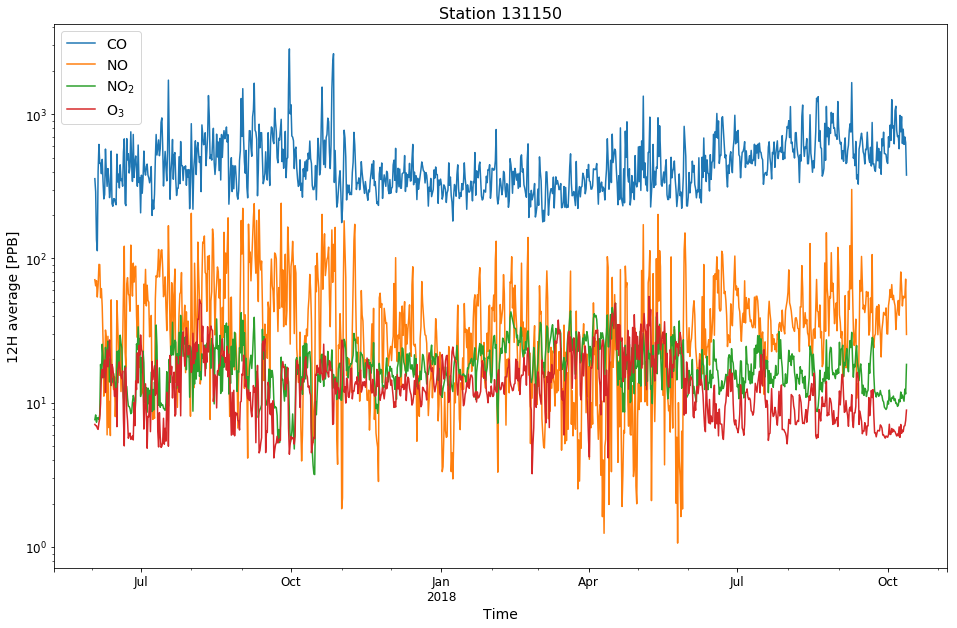

In [45]:
# figure setup
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

# adding lines to the axis
for sl, df in sorted(dfs_resampled.items()):
    df.plot(style='-', ms=5, fontsize=12, ax=ax)

# legend and scale(s)    
ax.legend([texify[key] for key in sorted(list(dfs_resampled.keys()))], fontsize=14)
ax.set_yscale('log')

# cosmetics
ax.set_ylabel(f"{resample_rule} average [PPB]", fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title(f"Station {stationID}", fontsize=16)


## Plotting with Plotly

In [10]:
data = []
for sl, df in sorted(dfs_resampled.items()):
    data.append(go.Scatter(x=df.index, 
                           y=getattr(df, f"{sl}_ts"),  # get data attribute of DataFrame
                           name=sl))  # latex doesn't work right now for plotly for some reason... 

# setting layout options
layout = go.Layout(showlegend=True, title=f"Station {stationID}", width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule} average [PPB]", 'type': "log"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig)

# Forecasting
a humble approach

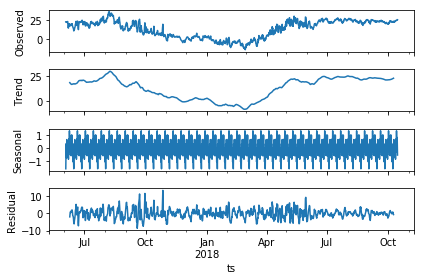

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

to_decompose = T_df_resampled['TEMP'].TEMP_ts

sd = sm.tsa.seasonal_decompose(to_decompose)
sd.plot()

result = sm.tsa.stattools.adfuller(to_decompose)

In [6]:
meas = 'TEMP'
threshold = 700
#train_df = dfs_resampled[meas][:threshold]
#test_df = dfs_resampled[meas][threshold:]

train_T = T_df_resampled['TEMP'][:threshold]
test_T = T_df_resampled['TEMP'][threshold:]

train_df = train_T
test_df = test_T

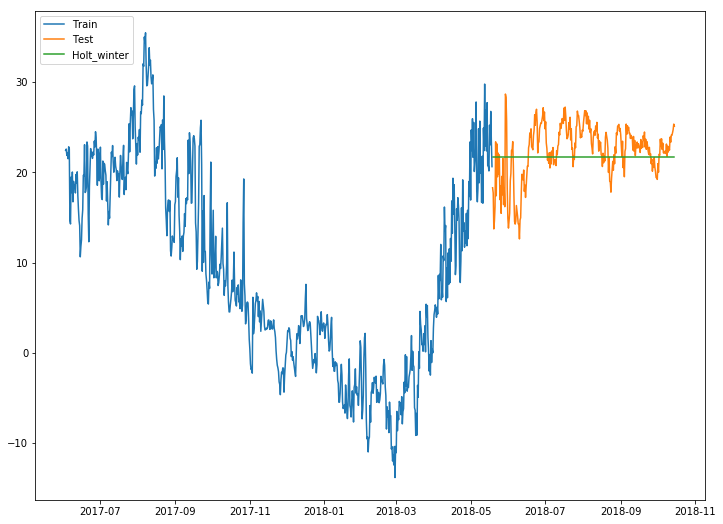

In [99]:
y_hat_avg = test_df.copy()


# fit1 = ExponentialSmoothing(np.asarray(train_df[f"{meas}_ts"]), seasonal_periods=2, seasonal='add', trend='add').fit()
fit1 = Holt(np.asarray(train_df[f"{meas}_ts"])).fit() # (smoothing_level = 0.3,smoothing_slope = 0.7)
y_hat_avg['Holt_winter'] = fit1.forecast(len(test_df))


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

ax.plot(train_df[f"{meas}_ts"], label='Train')
ax.plot(test_df[f"{meas}_ts"], label='Test')
ax.plot(y_hat_avg['Holt_winter'], label='Holt_winter')
ax.legend(loc=2)


In [7]:
import pyramid
from pyramid.arima import auto_arima

stepwise_model = auto_arima(train_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


AttributeError: module 'pyramid' has no attribute '__version__'

In [56]:
a = []

In [57]:
a.remove?